<a href="https://colab.research.google.com/github/seoyun2/exploration/blob/main/Exploration3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 3.카메라 스티커앱 만들기 

## 3-1. 카메라 스티커앱 만들기 첫걸음
__일단 한번 만들어보자__


이번 코스를 통해 
1. 카메라앱 만들기를 통해 __동영상 처리, 검출, 키포인트 추정, 추적, 카메라 원근__ 의 기술을 다룸 
2. 간단한 스티커부터 시작해서 각도 변화가 가능하고 거리 변화에 강건한 스티커 까지 만들 수 있음


이번 시간의 목표

1. 얼굴인식 카메라의 흐름을 이해
2. dlib 라이브러리 사용
3. 이미지 배열의 인덱싱 예외 처리

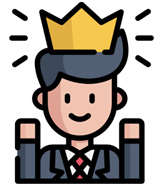

## 3-2. 사진 준비하기

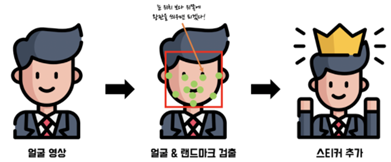

스티커를 세밀하고 자연스럽게 적용하기 위해서 눈, 코, 입, 귀와 같은 얼굴 각각의 위치를 아는 것이 중요 

이 위치들을 찾아내는 기술을 __랜드마크__ __*landmark*__ 또는 __조정__ __*alignment*__라고 함 

따라서, 
1. 얼굴이 포함된 사진을 준비
2. 사진으로부터 __얼굴영역 *face landmark*__를 찾아냄 (*landmark* 를 찾기 위해서는 *얼굴의 bounding box* 를 먼저 찾아야함)
3. 찾아진 영역으로 부터 머리에 왕관 스티커 붙여넣기 

왕관, 테스트할 모델 이미지
`'aiffel/camera_sticker/image'` 에 저장 & 드라이브 연결 

In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [3]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

이미지 처리를 위해 opencv와 노트북에 이미지를 출력하기 위한 matplotlib를 읽어오기

* 편의를 위해 이미지 크기 변경

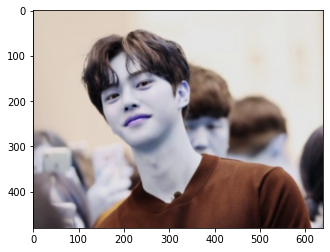

In [4]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/image.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

opencv의 특징으로 푸른색을 띔

* matplotlib, dlib 등의 이미지 라이브러리는 모두 이미지 채널을 RGB순으로 사용하지만 opencv는 예외적으로 BGR을 사용하기 때문에 opencv에서 다룬 이미지를 다른 이미지 라이브러리를 활용하여 출력하려면 색깔 보정 필요 

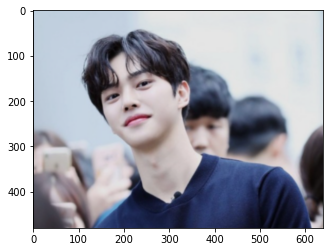

In [5]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## 3-3. 얼굴 검출 face detection

Object detection 기술을 이용해서 얼굴의 위치를 찾을 수 있음

dlib 의 face detector는 HOG(Histogram of Oriented Gradient) feature를 사용해서 SVM(Support Vector Machine)의 sliding window로 얼굴을 찾음

`dlib`을 활용해 `hog detector`를 선언

In [6]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

`detector`를 이용해서 얼굴의 `bounding box`를 추출
* dlib은 rgb 이미지를 입력으로 받기 때문에 `cvtColor()` 를 이용해서 opencv 의 bgr 이미지를 rgb로 변환

* `detector_hog`의 두 번째 파라미터는 이미지 피라미드의 수.

    이미지를 upsampling 방법을 통해 크기를 키우는 것을 이미지 피라미드

    이미지 피라미드에서 얼굴을 다시 검출하면 작게 촬영된 얼굴을 크게 볼 수 있기 때문에 더 정확한 검출이 가능

    [Image Pyramids - gramman 0.1 documentation](https://opencv-python.readthedocs.io/en/latest/doc/14.imagePyramid/imagePyramid.html)

In [7]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

찾은 얼굴 출력

rectangles[[(118, 98) (304, 284)]]


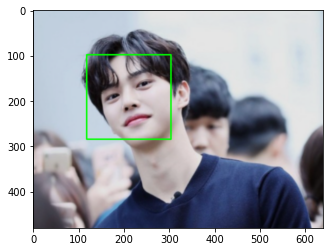

In [8]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3-4. 얼굴 랜드마크

스티커를 섬세하게 적용하기 위해서는 이목구비의 위치를 아는 것이 중요 

이목구비의 위치를 추론하는 것을 *face landmark localization* 기술이라고 함

face landmark는 detection 의 결과물인 bounding box 로 잘라낸(crop) 얼굴 이미지를 이용

### Object keypoint estimation 알고리즘

Face landmark와 같이 객체 내부의 점을 찾는 기술을 object keypoint estimation이라고 함

keypoint를 찾는 알고리즘은 크게 2가지로 나눔

1. top-down : bounding box를 찾고 box 내부의 keypoint를 예측

2. bottom-up : 이미지 전체의 keypoint를 먼저 찾고 point 관계를 이용해 군집화 해서 box 생성

(이번 예제에서는 1번 방식 사용)


__Dlib landmark localization__

잘라진 얼굴 이미지에서 아래 68개의 이목구비 위치를 찾음

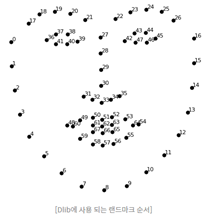

이 때 점의 개수는 데이터셋과 논문마다 다름. (AFLW 데이터셋은 21개를 사용하고 ibug 300w 데이터셋은 68개를 사용)

***
Dlib의 제공되는 모델을 사용

1. 공개되어 있는 weight file을 다운
2. 압축 풀기

In [ ]:
cd /content/gdrive/My Drive/aiffel/camera_sticker/models

/content/gdrive/My Drive/aiffel/camera_sticker/models


In [ ]:
!ls

shape_predictor_68_face_landmarks.zip


In [ ]:
!unzip -qq /content/gdrive/My\ Drive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.zip

In [ ]:
!ls

shape_predictor_68_face_landmarks.dat  shape_predictor_68_face_landmarks.zip


저장한 landmark 모델 불러오기

In [9]:
import os
model_path = '/content/gdrive/My Drive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

`landmark_predictor` 는 `RGB 이미지`와 `dlib.rectangle`을 입력 받아 `dlib.full_object_detection` 를 반환

In [10]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


> `points` 는 `dlib.full_object_detection` 의 객체이기 때문에 `parts(`) 함수로 개별 위치에 접근할 수 있음. 
>
> 조금 더 직관적인 (x, y) 형태로 접근할 수 있도록 변환
>
> 따라서 `list_points` 는 tuple (x, y) 68개로 이루어진 리스트가 되고  이미지에서 찾아진 얼굴 개수마다 반복하면 list_landmark에 68개의 랜드마크가 얼굴 개수만큼 저장

랜드마크 영상에 출력

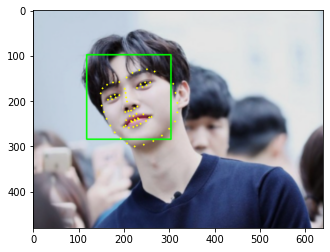

In [11]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## 3-5. 스티커 적용하기 
랜드마크 기준으로 '눈썹 위 얼굴 중앙'에 스티커 씌우면 됨

1. 스티커 위치
 
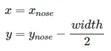

2. 스티커 크기 

image.png



좌표 먼저 확인

In [12]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    print (landmark[30]) # nose center index : 30
    x = landmark[30][0]
    y = landmark[30][1] - dlib_rect.width()//2
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(207, 201)
(x,y) : (207,108)
(w,h) : (187,187)


> 송강 얼굴 이미지에서는 코의 중심점이 `(207, 108)`

준비해 둔 스티커 이미지를 읽어서 적용 
* 왕관 이미지를 읽고 윗 단계에서 계산한 크기로 resize

In [13]:
import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/king.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print (img_sticker.shape)

(187, 187, 3)


원본 이미지에 스티커 이미지를 추가하기 위해 `x`, `y` 좌표 조정 (이미지 시작점은 top-left 좌표이기 때문에)

In [14]:
refined_x = x - w // 2  # left
refined_y = y - h       # top
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (114,-79)


> 출력값을 보면 음수가 계산된 것을 볼 수 있음
>
> opencv 데이터는 numpy ndarray 형태의 데이터를 사용. ndarray는 음수 인덱스에 접근할 수 없기 때문에 음수에 대한 예외 처리 해야함
>
> 원본 이미지의 범위를 벗어난 스티커 부분을 제거 

`-y` 크기만큼 스티커 crop

In [15]:
img_sticker = img_sticker[-refined_y:]
print (img_sticker.shape)

(108, 187, 3)


top 의 `y` 좌표는 원본 이미지의 경계 값으로 수정

In [16]:
refined_y = 0
print ('(x,y) : (%d,%d)'%(refined_x, refined_y))

(x,y) : (114,0)


원본 이미지에 스티커 적용 

In [17]:
sticker_area = img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_show[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)

> sticker_area는 원본이미지에서 스티커를 적용할 위치를 crop한 이미지 
>
> 예제에서는 (566,0) 부터 (566+268, 0+157) 범위의 이미지를 의미
>
> 스티커 이미지에서 사용할 부분은 0 이 아닌 색이 있는 부분을 사용
>
> 따라서 `np.where`를 통해 img_sticker 가 0 인 부분은 sticker_area를 사용하고 0이 아닌 부분을 img_sticker를 사용

결과 이미지를 출력

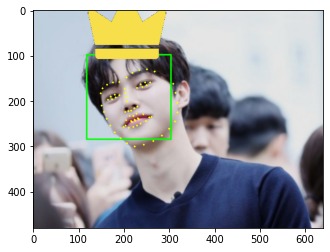

In [18]:
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

bounding box와 landmark를 제거하고 최종 결과만 출력

(`img_show` 대신, 지금까지 아껴 두었던 `img_rgb`를 활용)

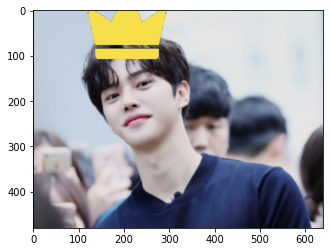

In [19]:
sticker_area = img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,sticker_area,img_sticker).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

# 프로젝트 : 고양이 수염 스티커 만들기 

## STEP1. 사진 준비하기 

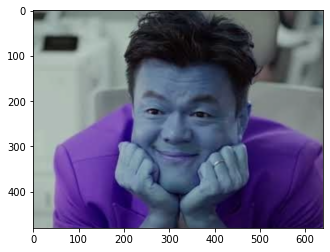

In [20]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/jyp2.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (640, 480))    
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

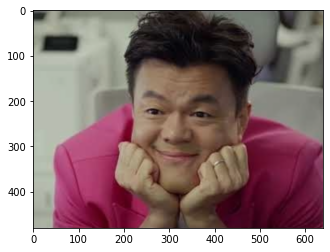

In [21]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

## STEP2. 얼굴 검출 

In [22]:
import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

In [23]:
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

rectangles[[(216, 167) (439, 390)]]


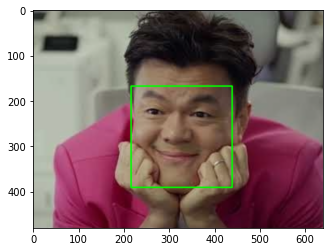

In [24]:
print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb =  cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## STEP3. 얼굴 랜드마크

In [25]:
import os
model_path = '/content/gdrive/My Drive/aiffel/camera_sticker/models/shape_predictor_68_face_landmarks.dat'
landmark_predictor = dlib.shape_predictor(model_path)

In [26]:
list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

68


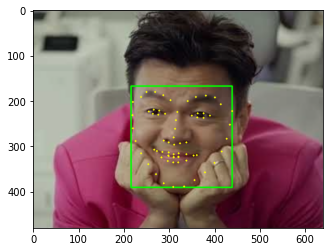

In [27]:
for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

## STEP4. 스티커 적용하기

힌트를 보면 랜드마크 2, 36, 48, 30 인덱스를 사용하라고 했지만 코에 고정하고 refined 하는게 더 잘됨

In [28]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1] 
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

(x,y) : (310,280)
(w,h) : (224,224)


In [29]:
import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

(224, 224, 3)


고양이 수염 사진을 bounded box에 맞춰서 resize 했기 때문에 코 좌표인 x에 w//2 해서 refined 해줌 

In [30]:
refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))

sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

(x, y) : (198, 168)
(224, 224, 3)


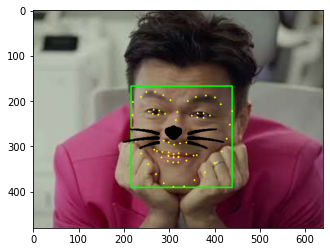

In [31]:
img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

추가적으로 반투명하게 고양이 수염을 적용하려면 addWeighted를 사용해 알파, 베타값을 0.5로 설정하였다.

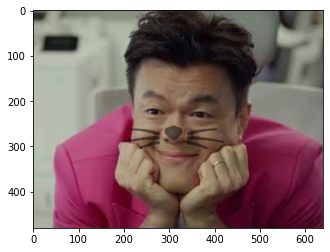

In [32]:
sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
     cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

## STEP5. 문제점 찾아보기 

### 최준

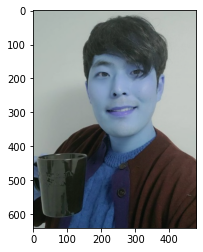

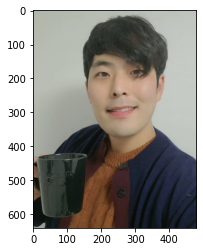

rectangles[[(142, 118) (365, 341)]]


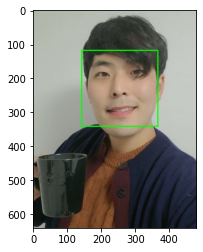

68


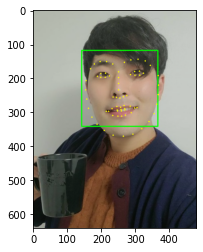

In [38]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/joon.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(x,y) : (250,234)
(w,h) : (224,224)
(224, 224, 3)
(x, y) : (138, 122)
(224, 224, 3)


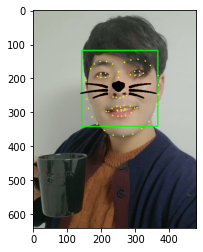

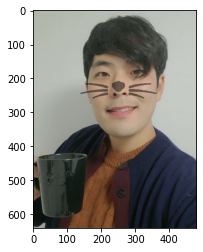

In [39]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8)


plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
img_bgr[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]] = \
    cv2.addWeighted(sticker_area, 0.5, np.where(img_sticker==0,img_sticker,sticker_area).astype(np.uint8), 0.5, 0)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()

### 송강 (거리멀때)

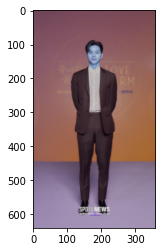

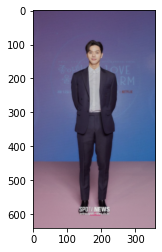

rectangles[[(156, 113) (199, 156)]]


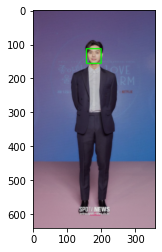

68


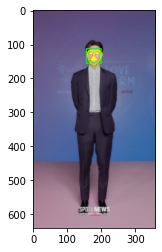

In [40]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/song_l.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (360, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

(x,y) : (177,135)
(w,h) : (44,44)
(44, 44, 3)
0.23579056028370643
(x, y) : (155, 113)
(44, 44, 3)


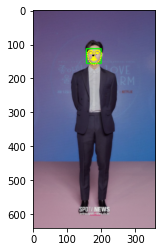

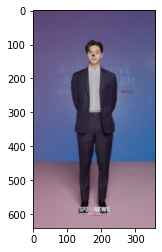

In [42]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

import math
rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rotate = cv2.warpAffine(img_sticker, rotate, (w, h), borderValue=(255, 255, 255))
plt.imshow(img_sticker_rotate)
plt.show

plt.imshow(img_sticker_rotate)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


### 한소희 (얼굴각도)

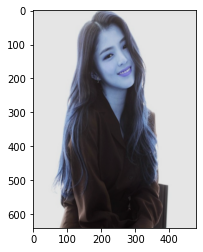

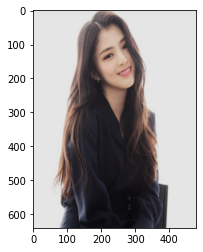

rectangles[[(196, 82) (325, 211)]]


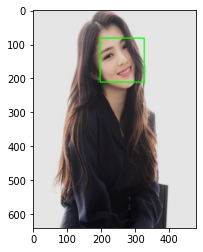

68


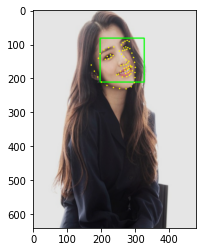

In [55]:
import os
my_image_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/han.png'
img_bgr = cv2.imread(my_image_path)    #- OpenCV로 이미지를 읽어서
img_bgr = cv2.resize(img_bgr, (480, 640))    # 640x360의 크기로 Resize
img_show = img_bgr.copy()      #- 출력용 이미지 별도 보관
plt.imshow(img_bgr)
plt.show()

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()

import dlib
detector_hog = dlib.get_frontal_face_detector()   #- detector 선언

img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
dlib_rects = detector_hog(img_rgb, 1)   #- (image, num of img pyramid)

print(dlib_rects)   # 찾은 얼굴영역 좌표

for dlib_rect in dlib_rects:
    l = dlib_rect.left()
    t = dlib_rect.top()
    r = dlib_rect.right()
    b = dlib_rect.bottom()

    cv2.rectangle(img_show, (l,t), (r,b), (0,255,0), 2, lineType=cv2.LINE_AA)

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

list_landmarks = []
for dlib_rect in dlib_rects:
    points = landmark_predictor(img_rgb, dlib_rect)
    list_points = list(map(lambda p: (p.x, p.y), points.parts()))
    list_landmarks.append(list_points)

print(len(list_landmarks[0]))

for landmark in list_landmarks:
    for idx, point in enumerate(list_points):
        cv2.circle(img_show, point, 2, (0, 255, 255), -1) # yellow

img_show_rgb = cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB)
plt.imshow(img_show_rgb)
plt.show()

#### 각도 해결하기

얼굴이 틀어져 있는 경우를 해결하고 싶어 두 벡터를 지정하고 arccos를 사용해 각도를 구하였다. 
<br>여러 좌표를 v2로 지정해봤는데, 오른쪽 눈머리와 왼쪽 입술 끝 가운데 지점이 가장 좋은 각도가 나왔다. 

In [47]:
v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

0.4871595129089828


(44, 44, 3)


<function matplotlib.pyplot.show>

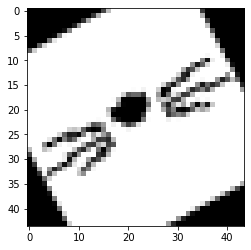

In [50]:
import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)
plt.imshow(img_sticker)
rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rot = cv2.warpAffine(img_sticker, rotate, (w, h))
plt.imshow(img_sticker_rot)
plt.show

(x,y) : (272,146)
(w,h) : (130,130)
(130, 130, 3)
0.48715951290898324
(x, y) : (207, 81)
(130, 130, 3)


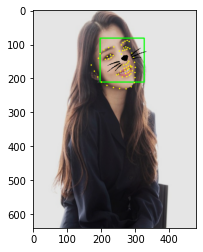

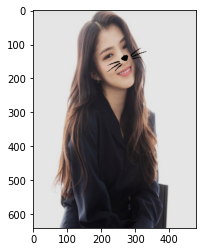

In [56]:
for dlib_rect, landmark in zip(dlib_rects, list_landmarks):
    x = landmark[30][0]
    y = landmark[30][1]
    w = dlib_rect.width()
    h = dlib_rect.width()
    print ('(x,y) : (%d,%d)'%(x,y))
    print ('(w,h) : (%d,%d)'%(w,h))

import os
sticker_path = '/content/gdrive/My Drive/aiffel/camera_sticker/images/cat.png'
img_sticker = cv2.imread(sticker_path)
img_sticker = cv2.resize(img_sticker, (w,h))
print(img_sticker.shape)

v1 = np.array([w, h])
v2 = np.array([landmark[42][0]+ (landmark[42][0]-landmark[48][0])//2, landmark[42][1]+ (landmark[42][1]-landmark[48][1])//2])

v12 = np.dot(v1 / np.linalg.norm(v1), v2 / np.linalg.norm(v2))
angle = np.arccos(v12)
print(angle)

rotate = cv2.getRotationMatrix2D((w/2, h/2), math.degrees(angle), 1)
img_sticker_rotate = cv2.warpAffine(img_sticker, rotate, (w, h), borderValue=(255, 255, 255))
plt.imshow(img_sticker_rotate)
plt.show

plt.imshow(img_sticker_rotate)

refined_x = x - w//2 
refined_y = y - h//2
print("(x, y) : ({}, {})".format(refined_x, refined_y))


sticker_area = img_show[refined_y:refined_y + img_sticker.shape[0], refined_x:refined_x+img_sticker.shape[1]]
print(sticker_area.shape)

img_show[refined_y:refined_y + img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

sticker_area = img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]]
img_bgr[refined_y:refined_y+img_sticker_rotate.shape[0], refined_x:refined_x+img_sticker_rotate.shape[1]] = \
    np.where(img_sticker_rotate==0,img_sticker_rotate,sticker_area).astype(np.uint8)
plt.imshow(cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB))
plt.show()


## 회고
배운 내용들을 여러 사진에 적용해보았다. 

landmark를 통해 원하는 위치에 스티커를 붙일 수 있었다는 것이 흥미로웠다. 

각도에 대한 문제는 해결하였지만 촬영 거리가 멀어졌을때는 스티커가 잘 보이지 않았고 사진 자체가 회전되어 있을땐 bounding box자체가 얼굴을 인식하지 못하여 적용하지 못했다. 

누워있는 사진 또한 적용시켜보려했지만 bounding box가 생성되지 않았다. 

하지만 내 기준에 거리가 멀다고 생각했던 송강 얼굴자체의 인식은 잘되어서 인식률이 높다고 생각하였다. 

스티커 사진을 회전시켜 적용하고 싶어 대학생 3학년때 배우던 행렬연산 책을 들여다보며 angle을 구하기위해 arccos를 사용하는 등 많은 시도를 해보았다. 

`cv2.getRotationMatrix2D()`을 사용하여 위에서 구한 각도를 적용시켜 고양이 수염을 회전시켰고, `cv2.warpAffin()`을 통해 회전시킨 이미지를 적용하였다. 

고양이 수염 이미지는 `cv2.addWeighted()`를 통해 반투명하게 적용시킬 수 있었다. 

예전에 배운 개념들을 상기 시키면서 배웠던 개념들을 이렇게 사용할 수 있다는 것에 놀랐고 재미있었다. 

누워있는 사진, 회전된 사진에도 어떻게 하면 적용할 수 있을지 더 고민해보면 좋을 것 같다. 

참고한 링크 

[Python-opencv-이용하여-이미지-회전해서-출력하는-방법](https://davey.tistory.com/entry/Python-opencv-%EC%9D%B4%EC%9A%A9%ED%95%98%EC%97%AC-%EC%9D%B4%EB%AF%B8%EC%A7%80-%ED%9A%8C%EC%A0%84%ED%95%B4%EC%84%9C-%EC%B6%9C%EB%A0%A5%ED%95%98%EB%8A%94-%EB%B0%A9%EB%B2%95)

[백터와 백터의 내적 구하기](https://blog.naver.com/daon307/221916472732)

[두 벡터 사이 각도 구하기](https://ko.wikihow.com/%EB%91%90-%EB%B2%A1%ED%84%B0-%EC%82%AC%EC%9D%B4-%EA%B0%81%EB%8F%84-%EA%B5%AC%ED%95%98%EA%B8%B0)

[행렬연산 np.dot](https://krksap.tistory.com/1737)